# Exploratory Data Analysis: World Happiness Prediction (2015-2019)

### By Natalia López Gallego

-----------------------------------------------------------------------------



This notebook performs an exploratory data analysis (EDA) on world happiness datasets from 2015 to 2019. The data comes from the world happiness reports, which include variables such as GDP per capita, social support, life expectancy, freedom, generosity, and perception of corruption.

**Objectives**:
- Explore the distribution, correlations, and trends of the variables.
- Prepare the data to train a regression model that predicts the normalized `happiness_score` in the range [0, 10].

**Assumptions**:
- The datasets for different years have similar structures but inconsistent column names that will be standardized.
- Missing values will be handled through imputation or removal depending on their impact.

**Limitations**:
- Differences in columns between years may limit comparability.
- The amount of data per year is limited (~150-158 rows), which may affect the model's generalization.

#### Metadata
- **Author**: Natalia López Gallego
- **Python Version**: 3.12.10

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import scipy.stats as stats
from scipy.stats import  skew, kurtosis
from statsmodels.stats.outliers_influence import variance_inflation_factor

## 1. Data Loading and Cleaning

In this section, we load the datasets from 2015 to 2019, standardize the column names, convert them to `snake_case` format, and select only the common columns to facilitate analysis and modeling.

In [20]:
data = [
    "../data/external/2015.csv",
    "../data/external/2016.csv",
    "../data/external/2017.csv",
    "../data/external/2018.csv",
    "../data/external/2019.csv"
]

dfs = {}  # Dictionary to save DataFrames by year

for file in data:
    # Extract year from filename correctly
    year = file.split("/")[-1][:4]  # "2015.csv" → "2015"
    df = pd.read_csv(file)
    dfs[year] = df  # Save the DataFrame with key = year

In [21]:
for year, df in dfs.items():
    print(f"\n{year} DataFrame:\n")
    df.info()


2015 DataFrame:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158 entries, 0 to 157
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Country                        158 non-null    object 
 1   Region                         158 non-null    object 
 2   Happiness Rank                 158 non-null    int64  
 3   Happiness Score                158 non-null    float64
 4   Standard Error                 158 non-null    float64
 5   Economy (GDP per Capita)       158 non-null    float64
 6   Family                         158 non-null    float64
 7   Health (Life Expectancy)       158 non-null    float64
 8   Freedom                        158 non-null    float64
 9   Trust (Government Corruption)  158 non-null    float64
 10  Generosity                     158 non-null    float64
 11  Dystopia Residual              158 non-null    float64
dtypes: float64(9), int64(1), object(

In [22]:
# Diccionario of standar names by year
column_renames = {
    "2015": {
        "Country": "Country",
        "Region": "Region",
        "Happiness Rank": "Happiness Rank",
        "Happiness Score": "Happiness Score",
        "Standard Error": "Standard Error",
        "Economy (GDP per Capita)": "Economy",
        "Family": "Family",
        "Health (Life Expectancy)": "Health",
        "Freedom": "Freedom",
        "Trust (Government Corruption)": "Trust",
        "Generosity": "Generosity",
        "Dystopia Residual": "Dystopia Residual"
    },
    "2016": {
        "Country": "Country",
        "Region": "Region",
        "Happiness Rank": "Happiness Rank",
        "Happiness Score": "Happiness Score",
        "Lower Confidence Interval": "CI Lower",
        "Upper Confidence Interval": "CI Upper",
        "Economy (GDP per Capita)": "Economy",
        "Family": "Family",
        "Health (Life Expectancy)": "Health",
        "Freedom": "Freedom",
        "Trust (Government Corruption)": "Trust",
        "Generosity": "Generosity",
        "Dystopia Residual": "Dystopia Residual"
    },
    "2017": {
        "Country": "Country",
        "Happiness.Rank": "Happiness Rank",
        "Happiness.Score": "Happiness Score",
        "Whisker.high": "CI Upper",
        "Whisker.low": "CI Lower",
        "Economy..GDP.per.Capita.": "Economy",
        "Family": "Family",
        "Health..Life.Expectancy.": "Health",
        "Freedom": "Freedom",
        "Trust..Government.Corruption.": "Trust",
        "Generosity": "Generosity",
        "Dystopia.Residual": "Dystopia Residual"
    },
    "2018": {
        "Overall rank": "Happiness Rank",
        "Country or region": "Country",
        "Score": "Happiness Score",
        "GDP per capita": "Economy",
        "Social support": "Family",
        "Healthy life expectancy": "Health",
        "Freedom to make life choices": "Freedom",
        "Generosity": "Generosity",
        "Perceptions of corruption": "Trust"
    },
    "2019": {
        "Overall rank": "Happiness Rank",
        "Country or region": "Country",
        "Score": "Happiness Score",
        "GDP per capita": "Economy",
        "Social support": "Family",
        "Healthy life expectancy": "Health",
        "Freedom to make life choices": "Freedom",
        "Generosity": "Generosity",
        "Perceptions of corruption": "Trust"
    }
}

# Apply renaming to each DataFrame in dfs
for year, df in dfs.items():
    if year in column_renames:
        dfs[year] = df.rename(columns=column_renames[year])


In [23]:
def to_snake_case(column_name):
    column_name = column_name.lower() 
    column_name = re.sub(r'\s+', '_', column_name) 
    column_name = re.sub(r'[^\w\s]', '', column_name)  
    return column_name

# Apply renaming to each DataFrame in dfs
for year, df in dfs.items():
    # Renaming each column to snake_case
    df.columns = [to_snake_case(col) for col in df.columns]

In [24]:
# Obtener las columnas comunes entre todos los DataFrames
common_columns = set(dfs['2015'].columns)  # Iniciar con las columnas del primer DataFrame

# Iterar por los DataFrames y actualizar las columnas comunes
for year, df in dfs.items():
    common_columns &= set(df.columns)  # Intersección de columnas

# Convertir las columnas comunes a lista
common_columns = list(common_columns)

# Filtrar los DataFrames para que solo contengan las columnas comunes
for year, df in dfs.items():
    dfs[year] = df[common_columns]  # Filtra solo las columnas comunes

# Verificar el resultado
for year, df in dfs.items():
    print(f"DataFrame for {year} with common columns:\n", df.columns)

DataFrame for 2015 with common columns:
 Index(['happiness_score', 'freedom', 'happiness_rank', 'family', 'country',
       'economy', 'generosity', 'health', 'trust'],
      dtype='object')
DataFrame for 2016 with common columns:
 Index(['happiness_score', 'freedom', 'happiness_rank', 'family', 'country',
       'economy', 'generosity', 'health', 'trust'],
      dtype='object')
DataFrame for 2017 with common columns:
 Index(['happiness_score', 'freedom', 'happiness_rank', 'family', 'country',
       'economy', 'generosity', 'health', 'trust'],
      dtype='object')
DataFrame for 2018 with common columns:
 Index(['happiness_score', 'freedom', 'happiness_rank', 'family', 'country',
       'economy', 'generosity', 'health', 'trust'],
      dtype='object')
DataFrame for 2019 with common columns:
 Index(['happiness_score', 'freedom', 'happiness_rank', 'family', 'country',
       'economy', 'generosity', 'health', 'trust'],
      dtype='object')


## 2. Exploratory Data Analysis

We explore the structure of the data, check for missing values, analyze distributions, correlations, outliers, and temporal trends to better understand the variables and their relationship with `happiness_score`.

In [25]:
for year, df in dfs.items():
    print(f"DataFrame for {year} - Number of rows and columns:\n", df.shape)

DataFrame for 2015 - Number of rows and columns:
 (158, 9)
DataFrame for 2016 - Number of rows and columns:
 (157, 9)
DataFrame for 2017 - Number of rows and columns:
 (155, 9)
DataFrame for 2018 - Number of rows and columns:
 (156, 9)
DataFrame for 2019 - Number of rows and columns:
 (156, 9)


In [26]:
for year, df in dfs.items():
    print(f"Describe for {year}:\n", df.describe(), "\n")

Describe for 2015:
        happiness_score     freedom  happiness_rank      family     economy  \
count       158.000000  158.000000      158.000000  158.000000  158.000000   
mean          5.375734    0.428615       79.493671    0.991046    0.846137   
std           1.145010    0.150693       45.754363    0.272369    0.403121   
min           2.839000    0.000000        1.000000    0.000000    0.000000   
25%           4.526000    0.328330       40.250000    0.856823    0.545808   
50%           5.232500    0.435515       79.500000    1.029510    0.910245   
75%           6.243750    0.549092      118.750000    1.214405    1.158448   
max           7.587000    0.669730      158.000000    1.402230    1.690420   

       generosity      health       trust  
count  158.000000  158.000000  158.000000  
mean     0.237296    0.630259    0.143422  
std      0.126685    0.247078    0.120034  
min      0.000000    0.000000    0.000000  
25%      0.150553    0.439185    0.061675  
50%      0.21

In [27]:
# Función para detectar outliers usando IQR
def detect_outliers(df):
    outliers = {}
    for column in df.select_dtypes(include=[np.number]).columns:
        # Calcular los cuartiles
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1

        # Definir los límites para outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Detectar outliers
        outliers[column] = df[(df[column] < lower_bound) | (df[column] > upper_bound)].index.tolist()

    return outliers

# Iterar sobre los DataFrames para detectar outliers
for year, df in dfs.items():
    outliers = detect_outliers(df)
    print(f"Detected Outliers for {year}:\n", outliers, "\n")


Detected Outliers for 2015:
 {'happiness_score': [], 'freedom': [], 'happiness_rank': [], 'family': [147, 152, 157], 'economy': [], 'generosity': [33, 128], 'health': [], 'trust': [0, 2, 3, 5, 7, 8, 16, 19, 23, 27, 71, 90, 129, 153]} 

Detected Outliers for 2016:
 {'happiness_score': [], 'freedom': [], 'happiness_rank': [], 'family': [154], 'economy': [], 'generosity': [29, 32, 78, 118], 'health': [], 'trust': [0, 1, 3, 4, 7, 9, 19, 21, 27, 35, 96, 151]} 

Detected Outliers for 2017:
 {'happiness_score': [], 'freedom': [], 'happiness_rank': [], 'family': [142, 149, 151, 154], 'economy': [], 'generosity': [80, 113], 'health': [], 'trust': [0, 1, 3, 4, 7, 8, 9, 14, 17, 20, 25, 34, 150]} 

Detected Outliers for 2018:
 {'happiness_score': [], 'freedom': [136, 141], 'happiness_rank': [], 'family': [135, 149, 154], 'economy': [19], 'generosity': [95, 129], 'health': [], 'trust': [0, 1, 2, 4, 5, 6, 7, 8, 9, 13, 14, 16, 18, 33, 75, 97, 150]} 

Detected Outliers for 2019:
 {'happiness_score': [

In [29]:
# Iterar sobre los DataFrames y detectar valores nulos
for year, df in dfs.items():
    print(f"Null values for {year}:\n")

    # Mostrar los valores nulos por columna
    null_counts = df.isnull().sum()

    # Imprimir solo las columnas con valores nulos
    print(null_counts[null_counts > 0], "\n")

Null values for 2015:

Series([], dtype: int64) 

Null values for 2016:

Series([], dtype: int64) 

Null values for 2017:

Series([], dtype: int64) 

Null values for 2018:

trust    1
dtype: int64 

Null values for 2019:

Series([], dtype: int64) 



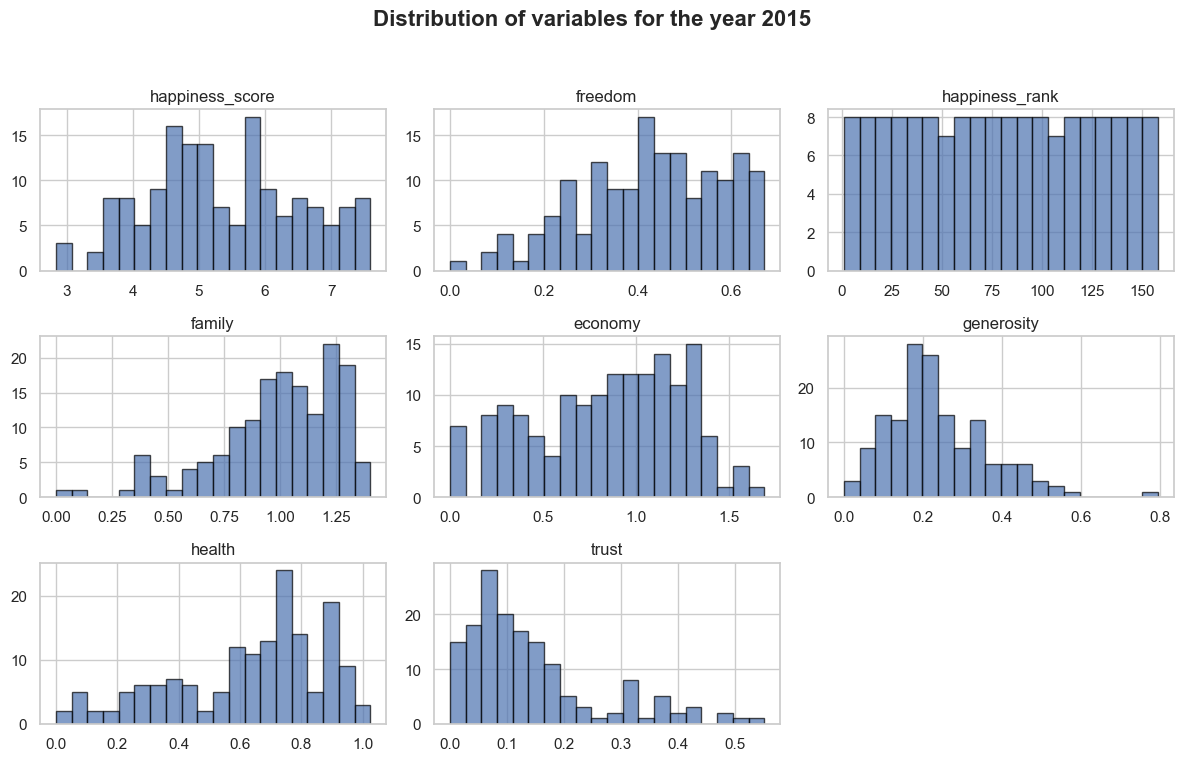

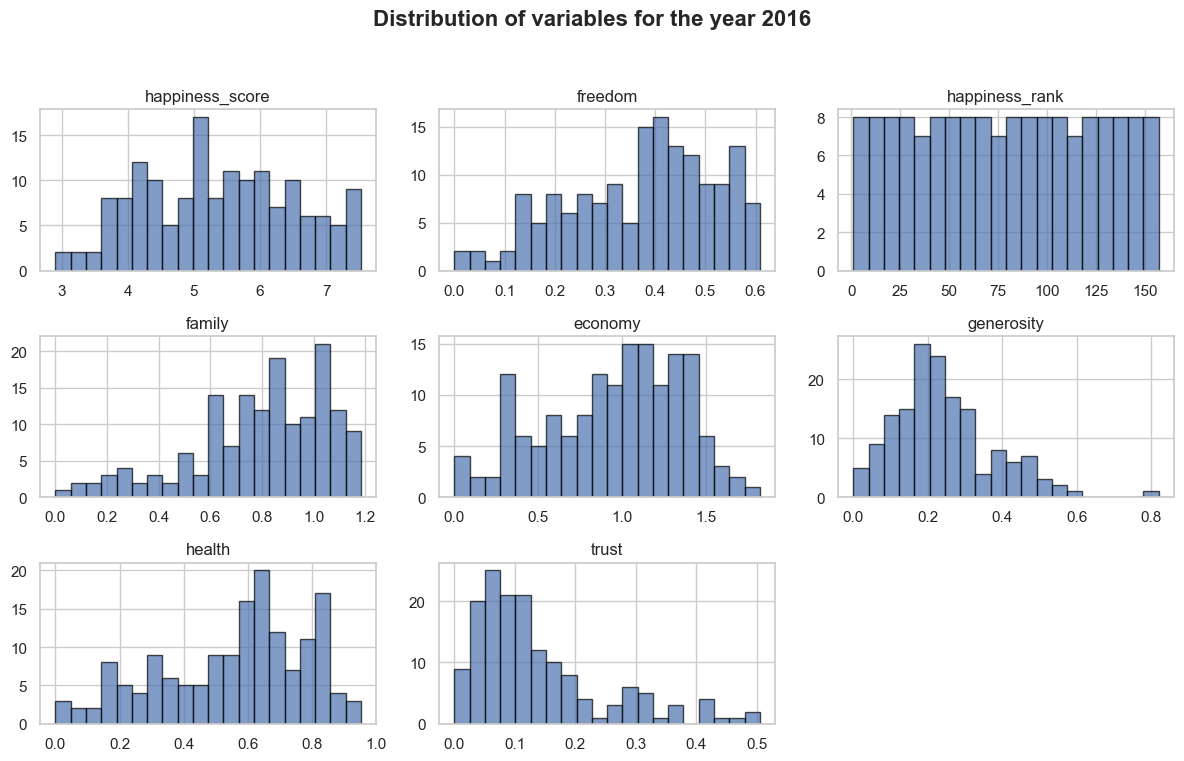

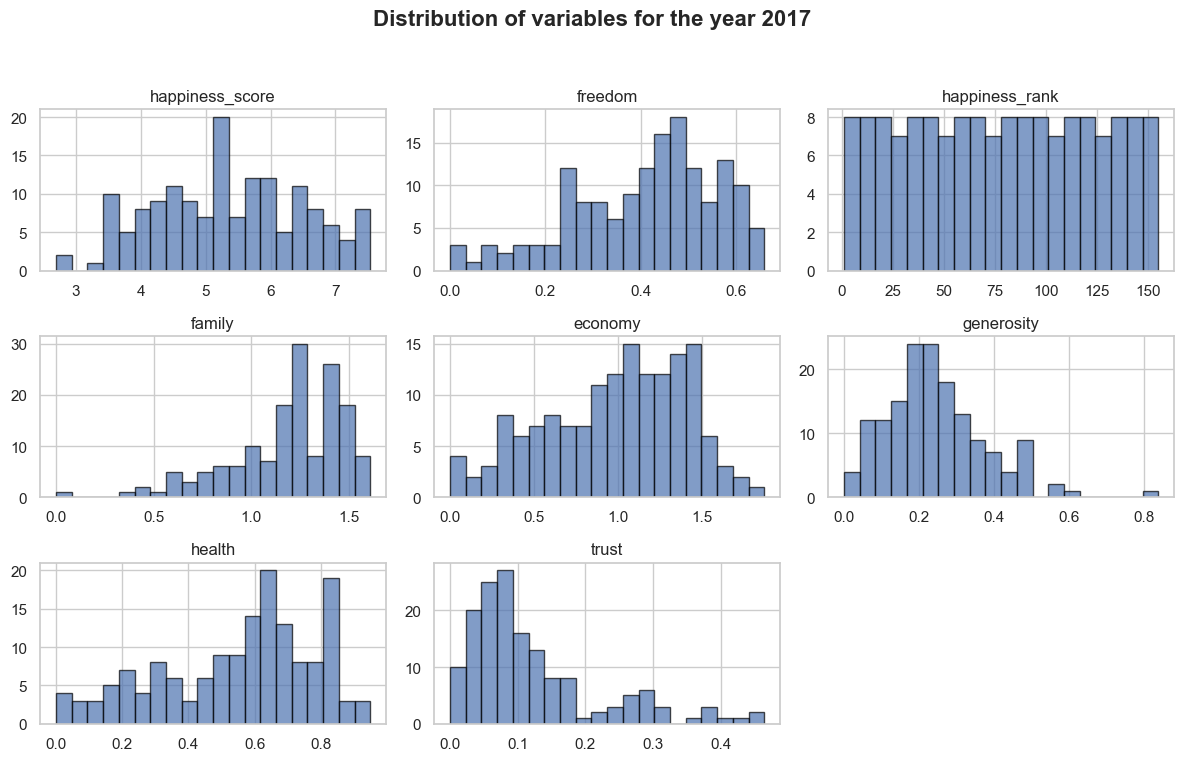

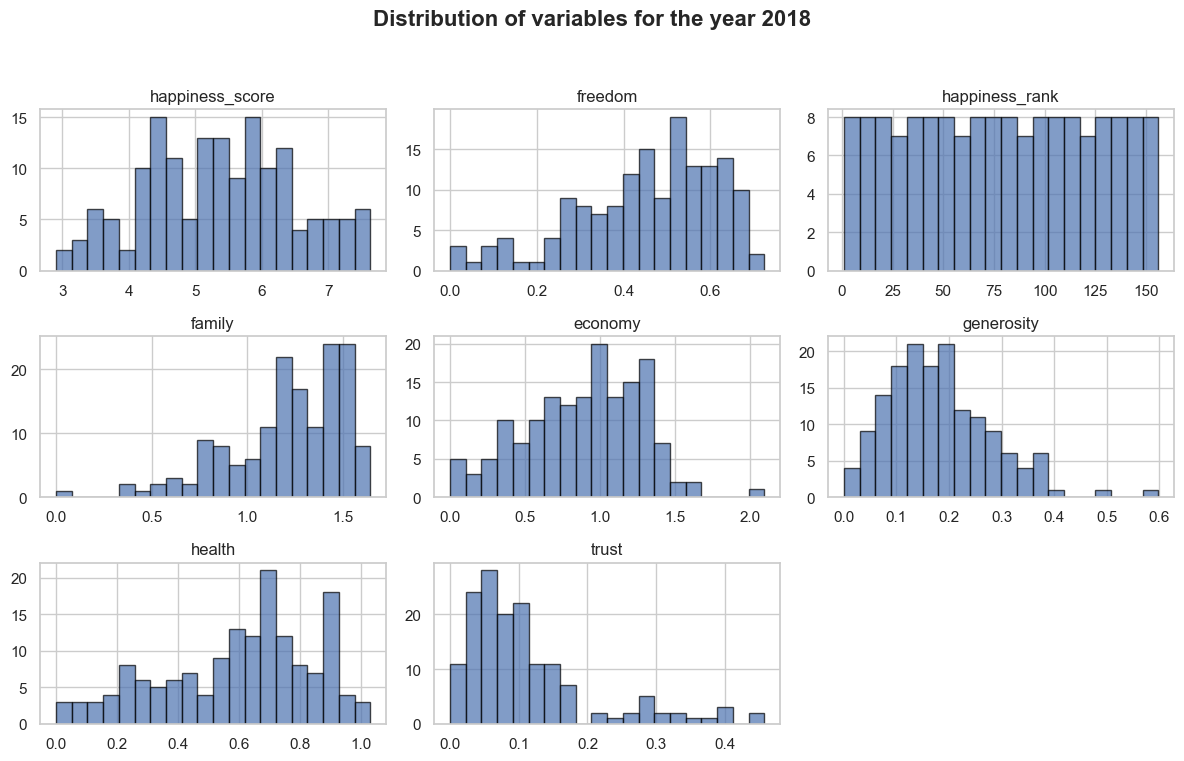

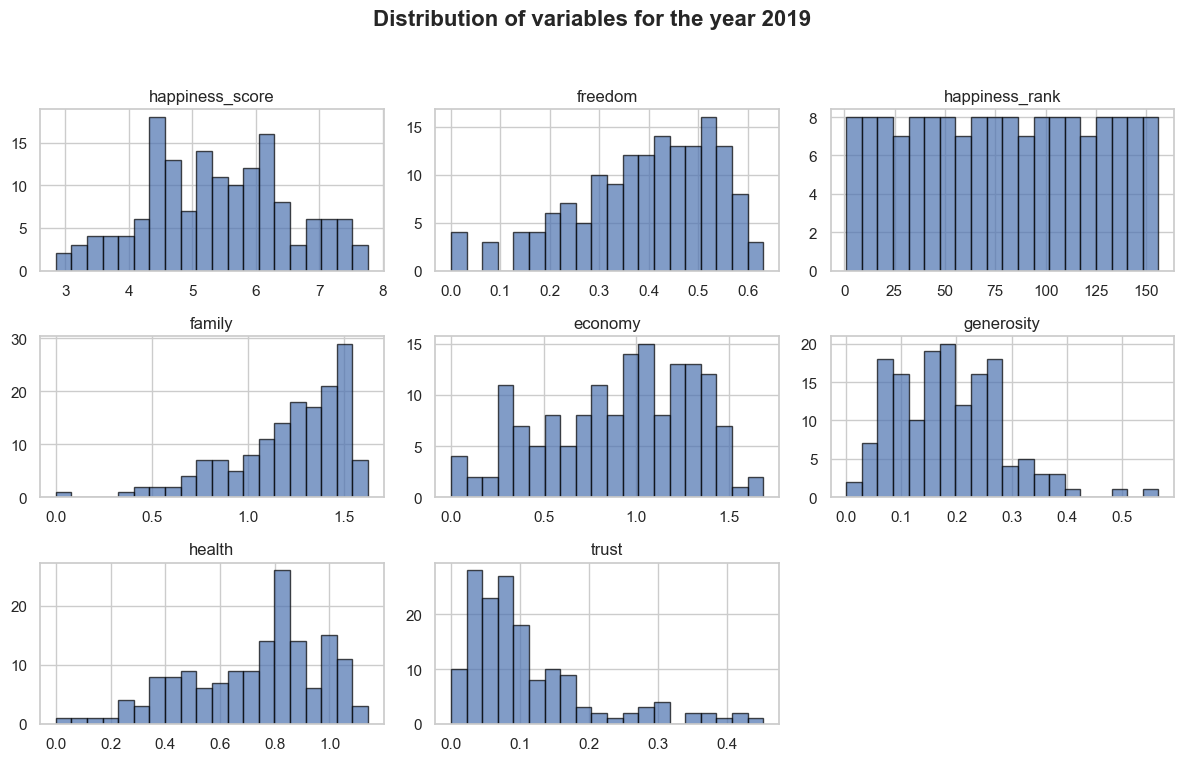

In [30]:
# Configuración estética de los gráficos
sns.set(style="whitegrid")  # Estilo de fondo blanco con líneas de cuadrícula
plt.rcParams["figure.figsize"] = (12, 8)  # Tamaño por defecto de las figuras

# Iterar sobre los DataFrames
for year, df in dfs.items():
    # Generar el histograma de todas las columnas numéricas
    df_numeric = df.select_dtypes(include=['number'])

    # Crear un histograma para cada columna numérica
    df_numeric.hist(bins=20, edgecolor='black', alpha=0.7)

    # Título y etiquetas
    plt.suptitle(f"Distribution of variables for the year {year}", fontsize=16, fontweight='bold')
    plt.xlabel('Value', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)

    # Ajustar el layout para que todo encaje bien
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    # Mostrar el gráfico
    plt.show()


### **Handling Null Values**

Como la distribución de `trust` para 2028 está sesgada a la derecha (right-skewed), la mediana es una opción más robusta que la media para imputar valores nulos. En este caso hay un solo valor nulo, y se manejará imputando la mediana.


In [31]:
#Calcular la mediana de 'trust' para 2018
median_trust_2018 = dfs['2018']['trust'].median()

# Imputar valores nulos con la mediana
dfs['2018']['trust'].fillna(median_trust_2018, inplace=True)

# Verificar que ya no hay valores nulos
print(dfs['2018']['trust'].isnull().sum())

0


### **Handling Outliers**

We're replacing values **greater than 10 and smaller than 1** with the **median** because these values likely represent **extreme outliers** that could distort the accuracy of predictive models. Here’s why this approach makes sense:

 Since `happiness_score` is measured **from 0 to 10**, any value outside this range is potentially an **error or anomaly**.

- **Median is robust to extreme values** → Unlike the mean, the median **does not shift due to outliers**.
- **Preserves the central tendency** → Instead of deleting data, replacing outliers with the median keeps the distribution balanced.

In [ ]:
# Iterate through each year in dfs
for year, df in dfs.items():
    for col in df.select_dtypes(include=["number"]).columns:  # Apply only to numeric columns
        median_value = df[col].median()  # Calculate median of the column
        df.loc[df[col] > 10, col] = median_value  # Replace values greater than 10
        df.loc[df[col] < 1, col] = median_value  # Replace values smaller than 1

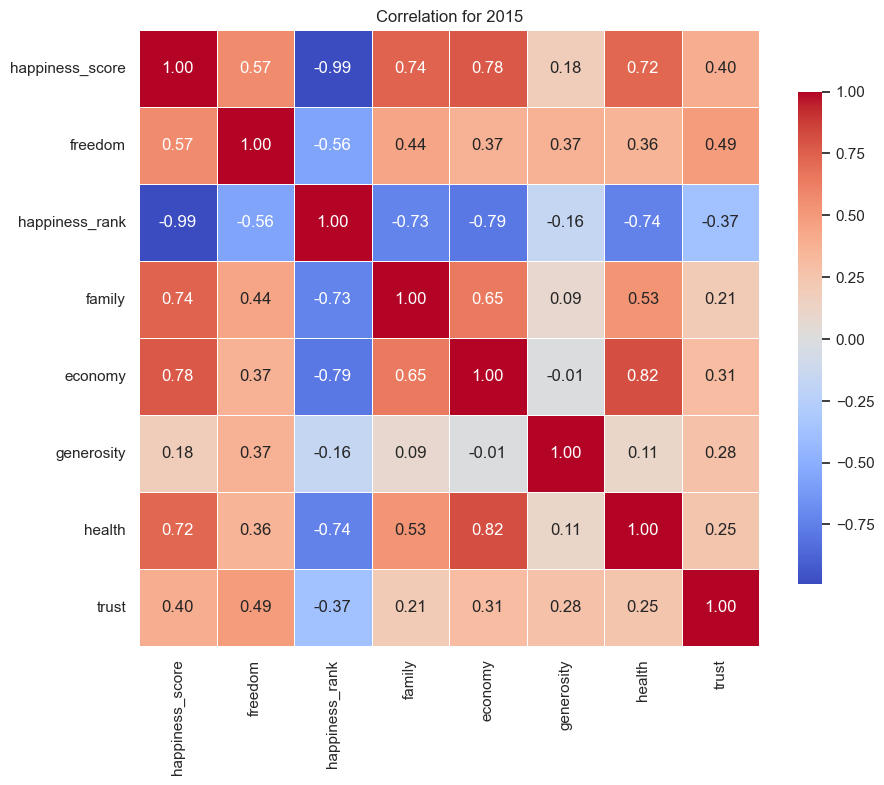

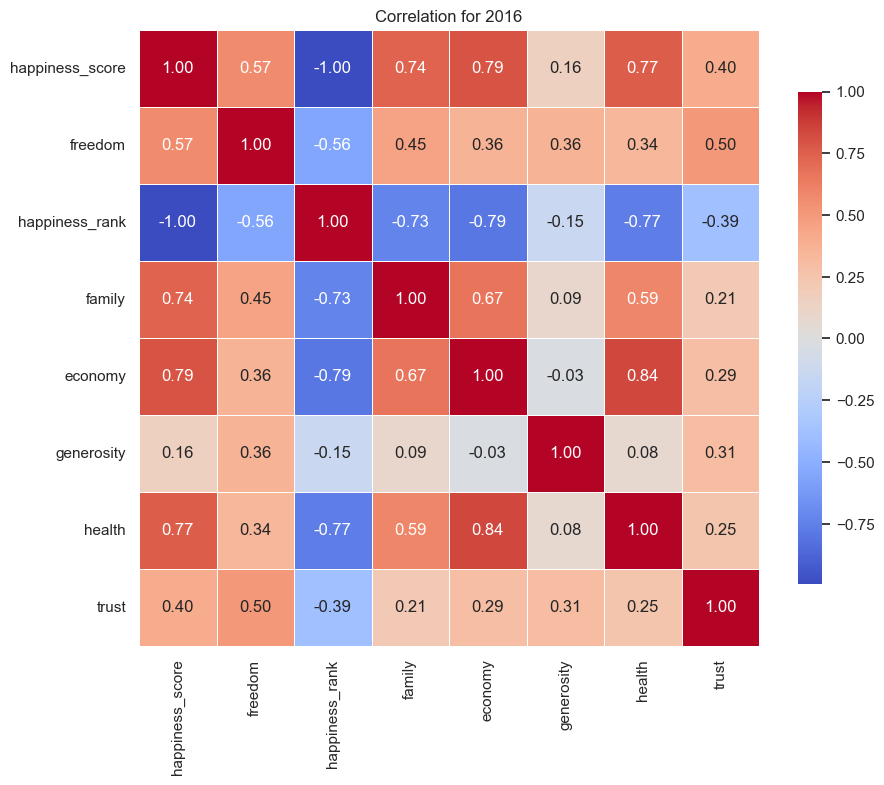

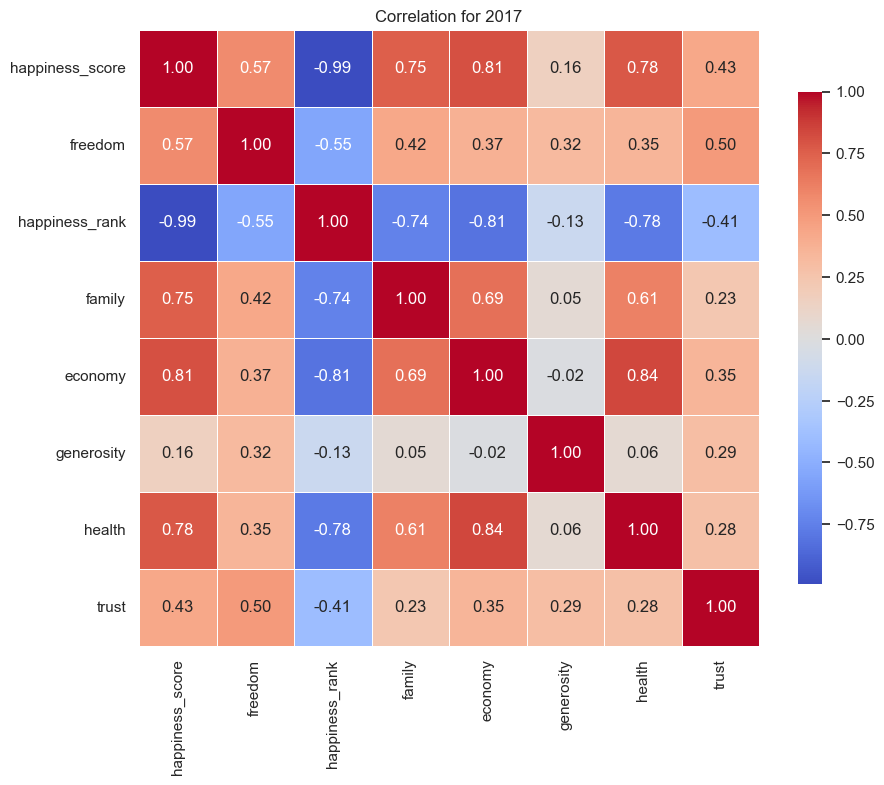

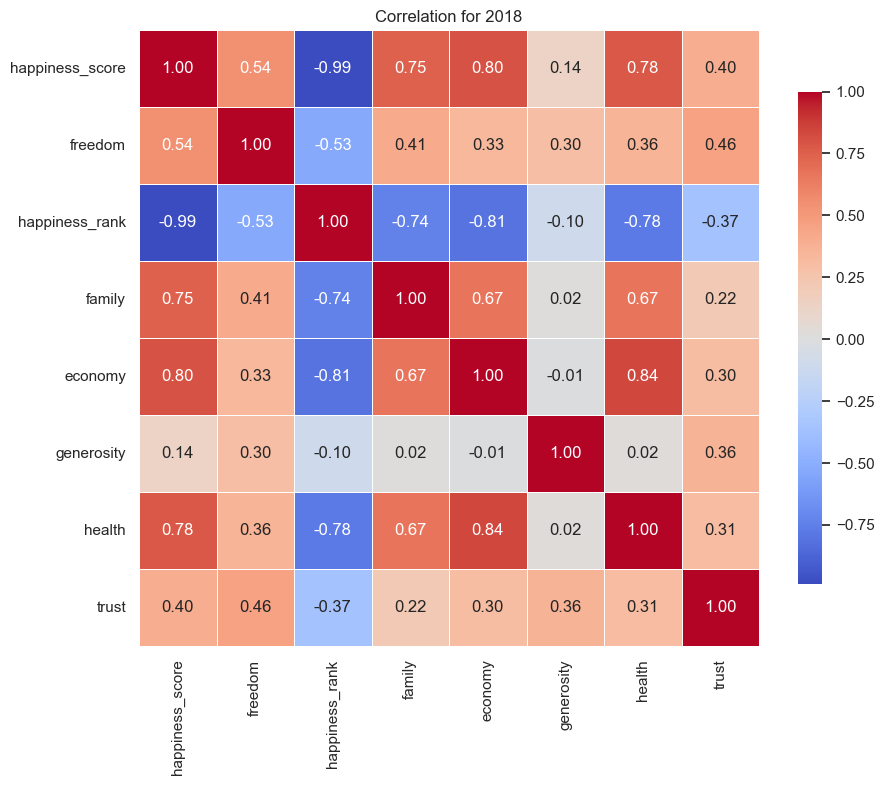

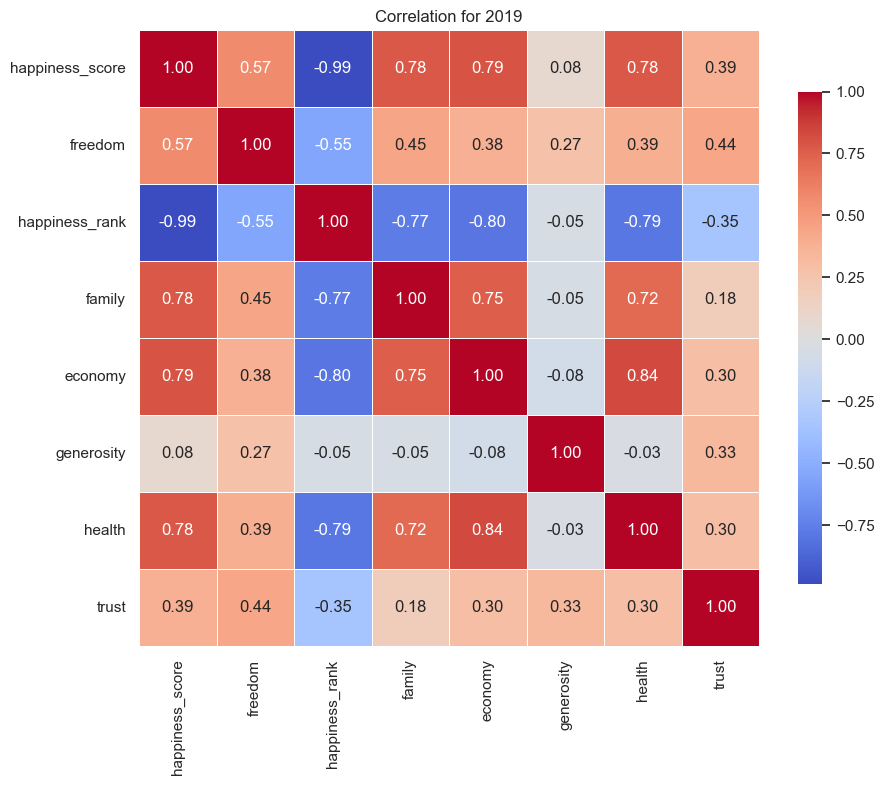

In [32]:
# Iterar sobre los DataFrames
for year, df in dfs.items():
    # Seleccionar solo las columnas numéricas (sin necesidad de eliminar la columna 'Country')
    df_numeric = df.select_dtypes(include=['number'])

    # Calcular la matriz de correlación para las columnas numéricas
    corr = df_numeric.corr()

    # Crear un mapa de calor para la matriz de correlación
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, cbar_kws={'shrink': 0.8})

    # Título del gráfico
    plt.title(f"Correlation for {year}")
    plt.show()

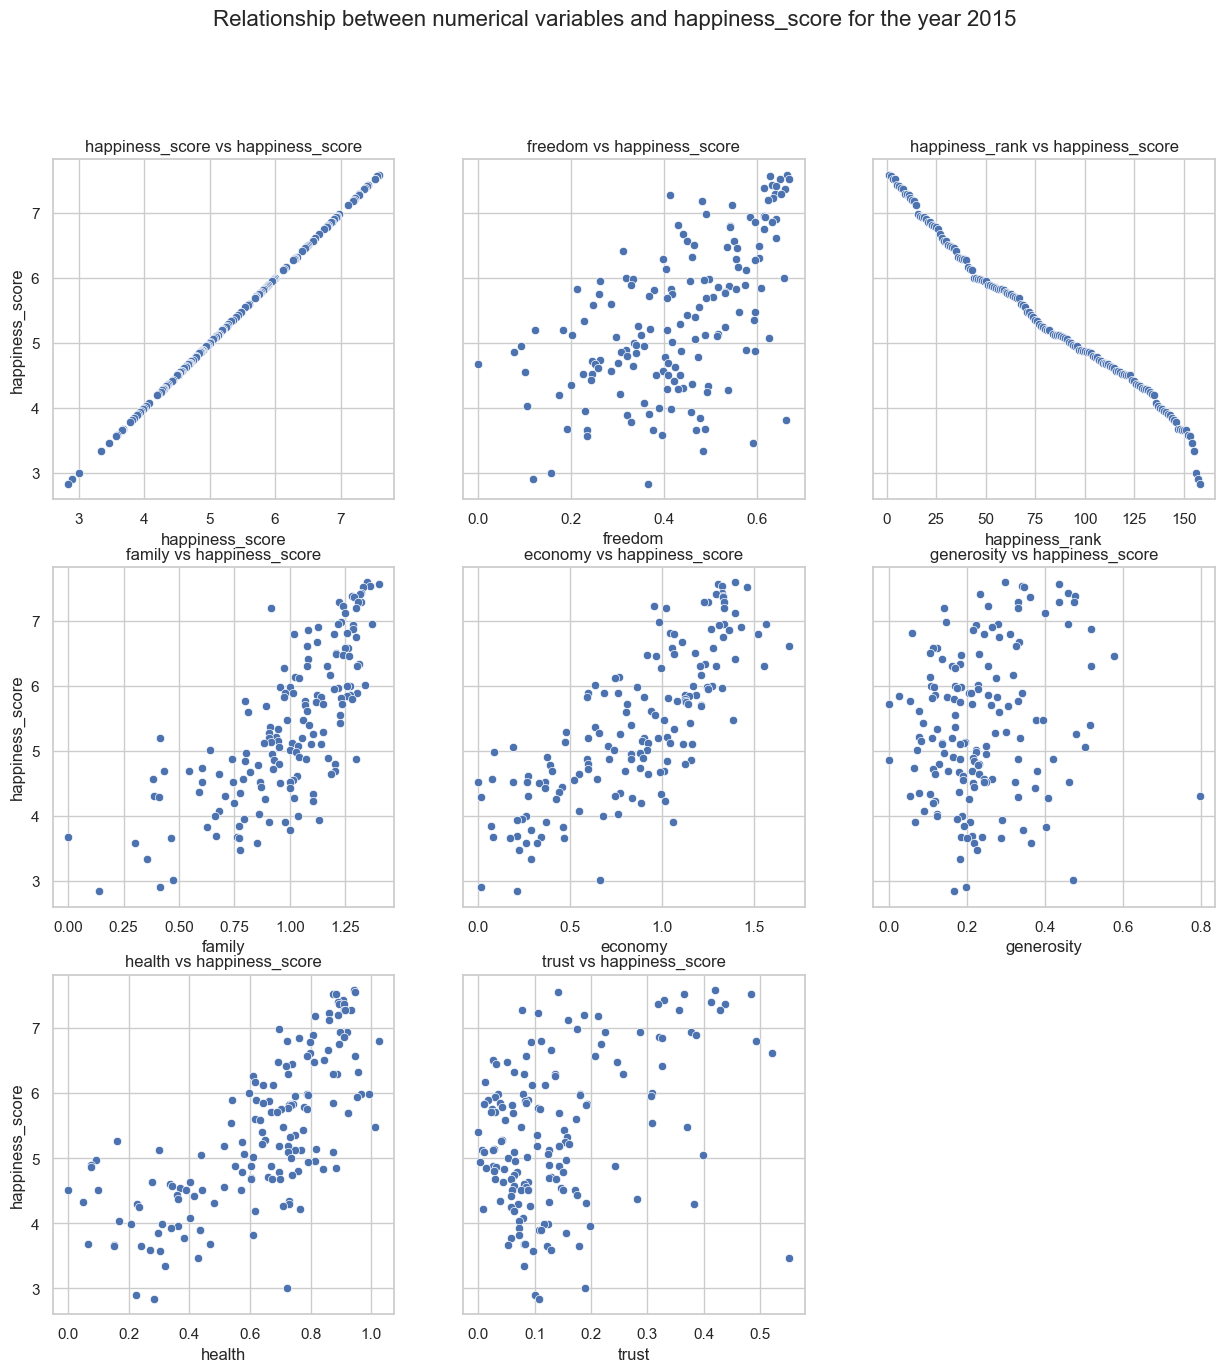

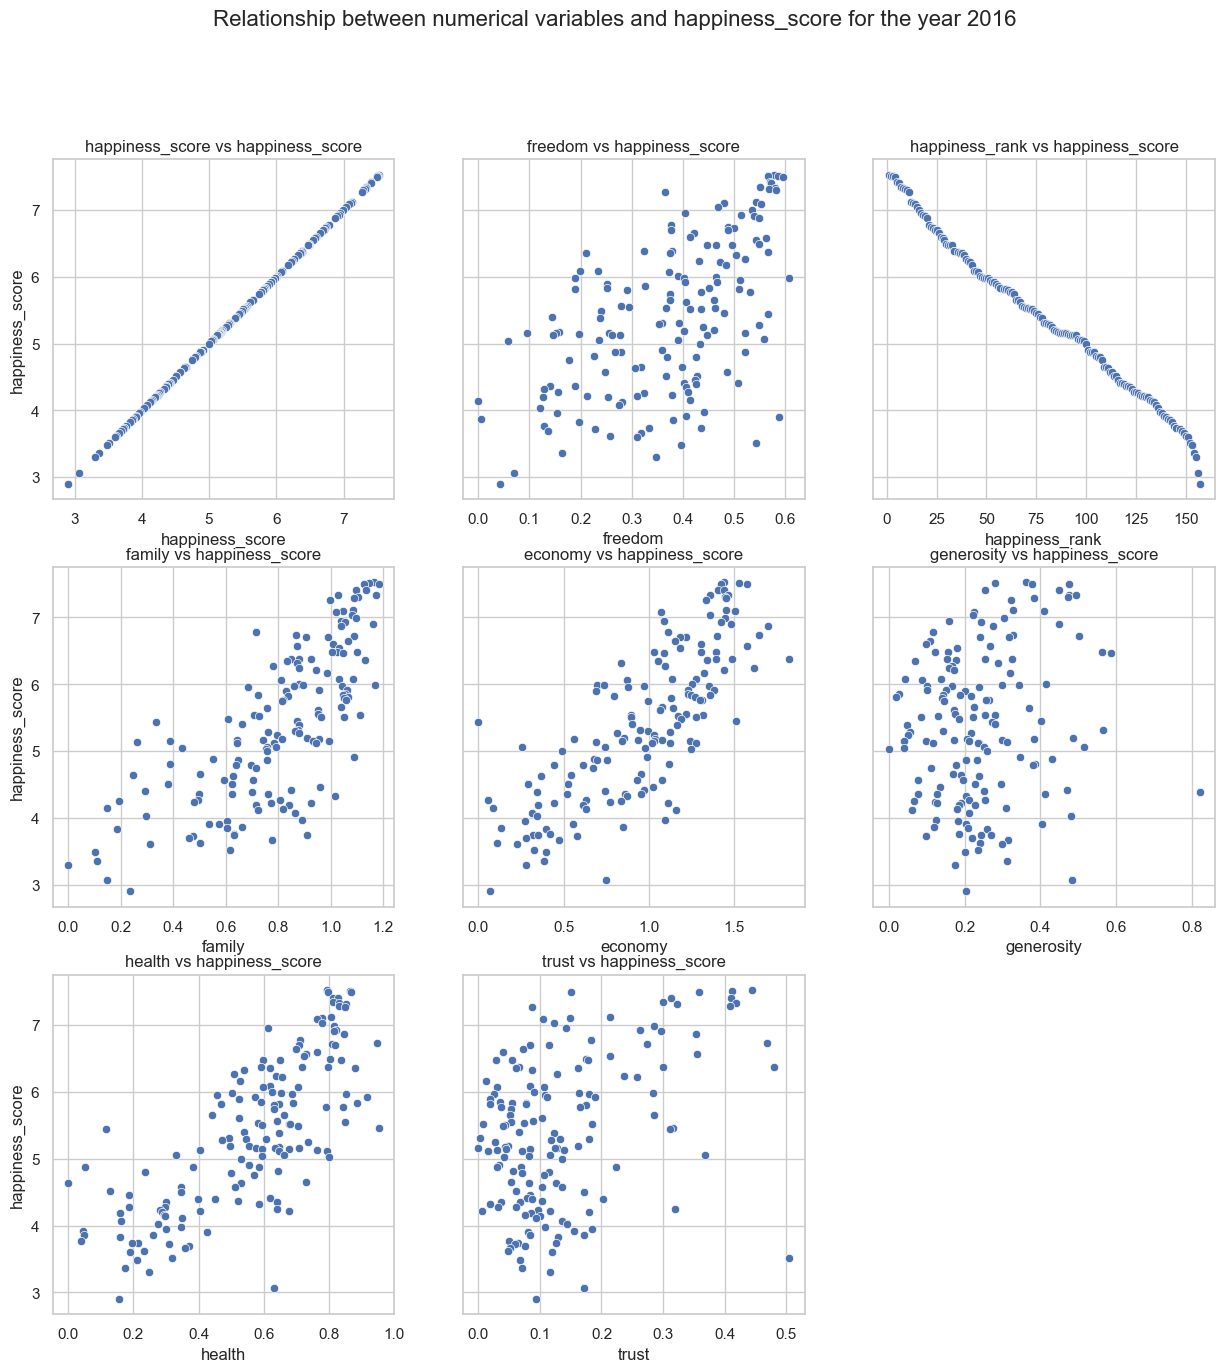

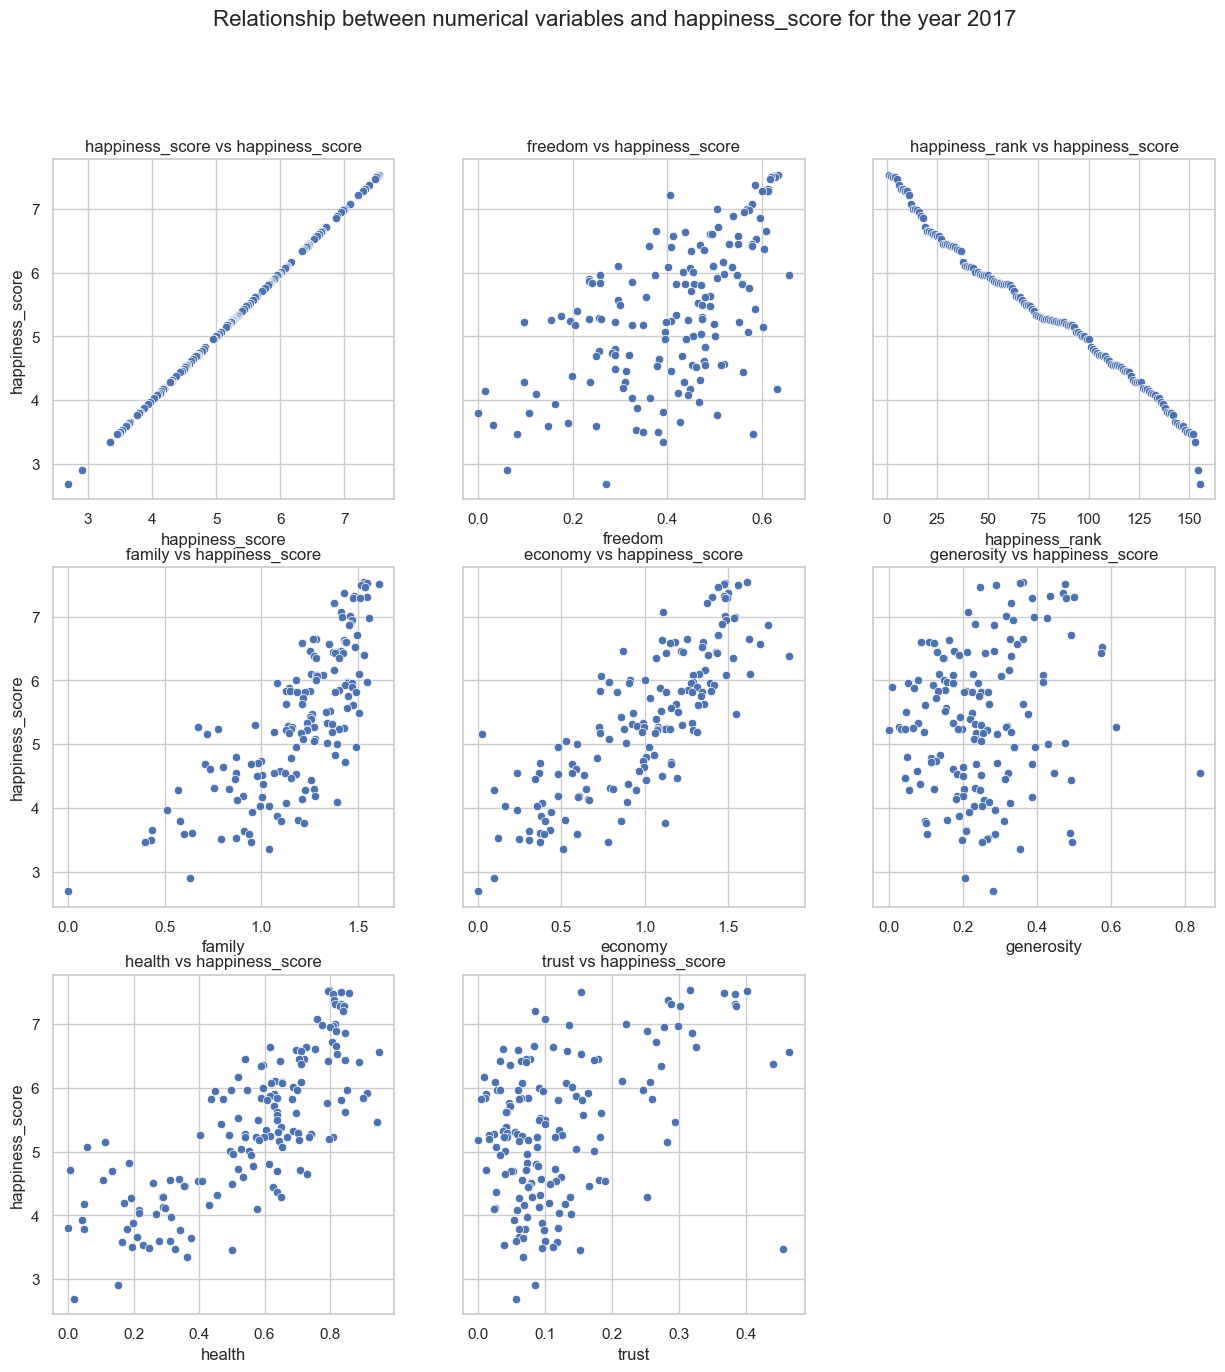

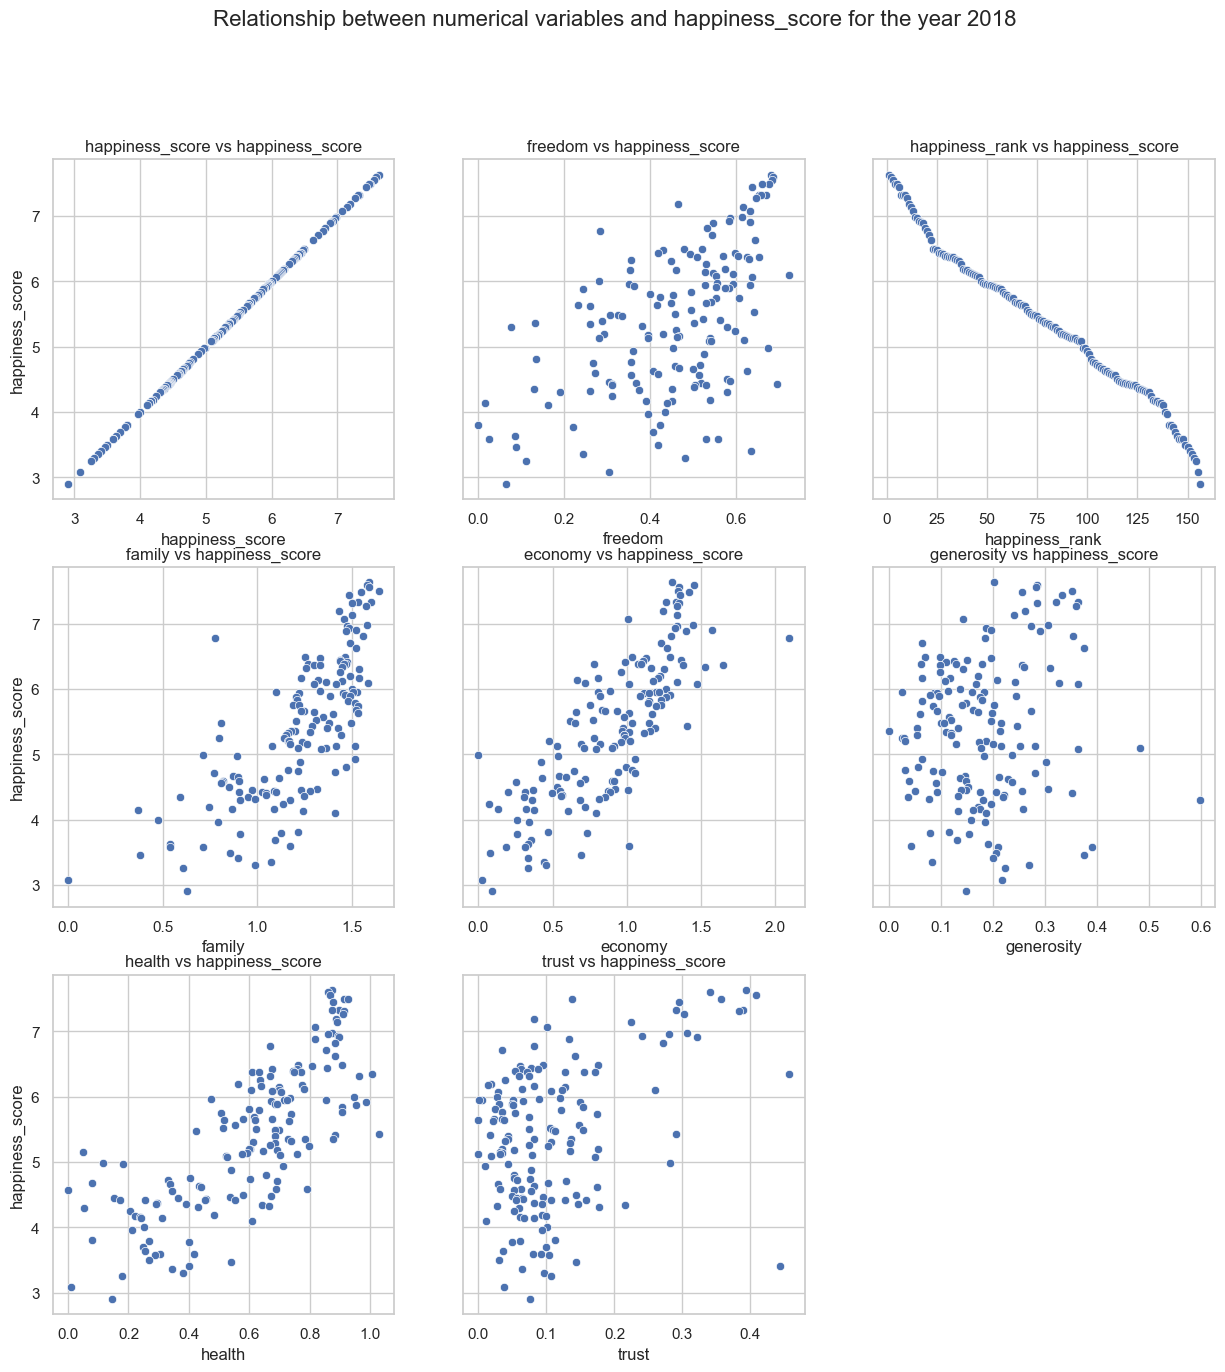

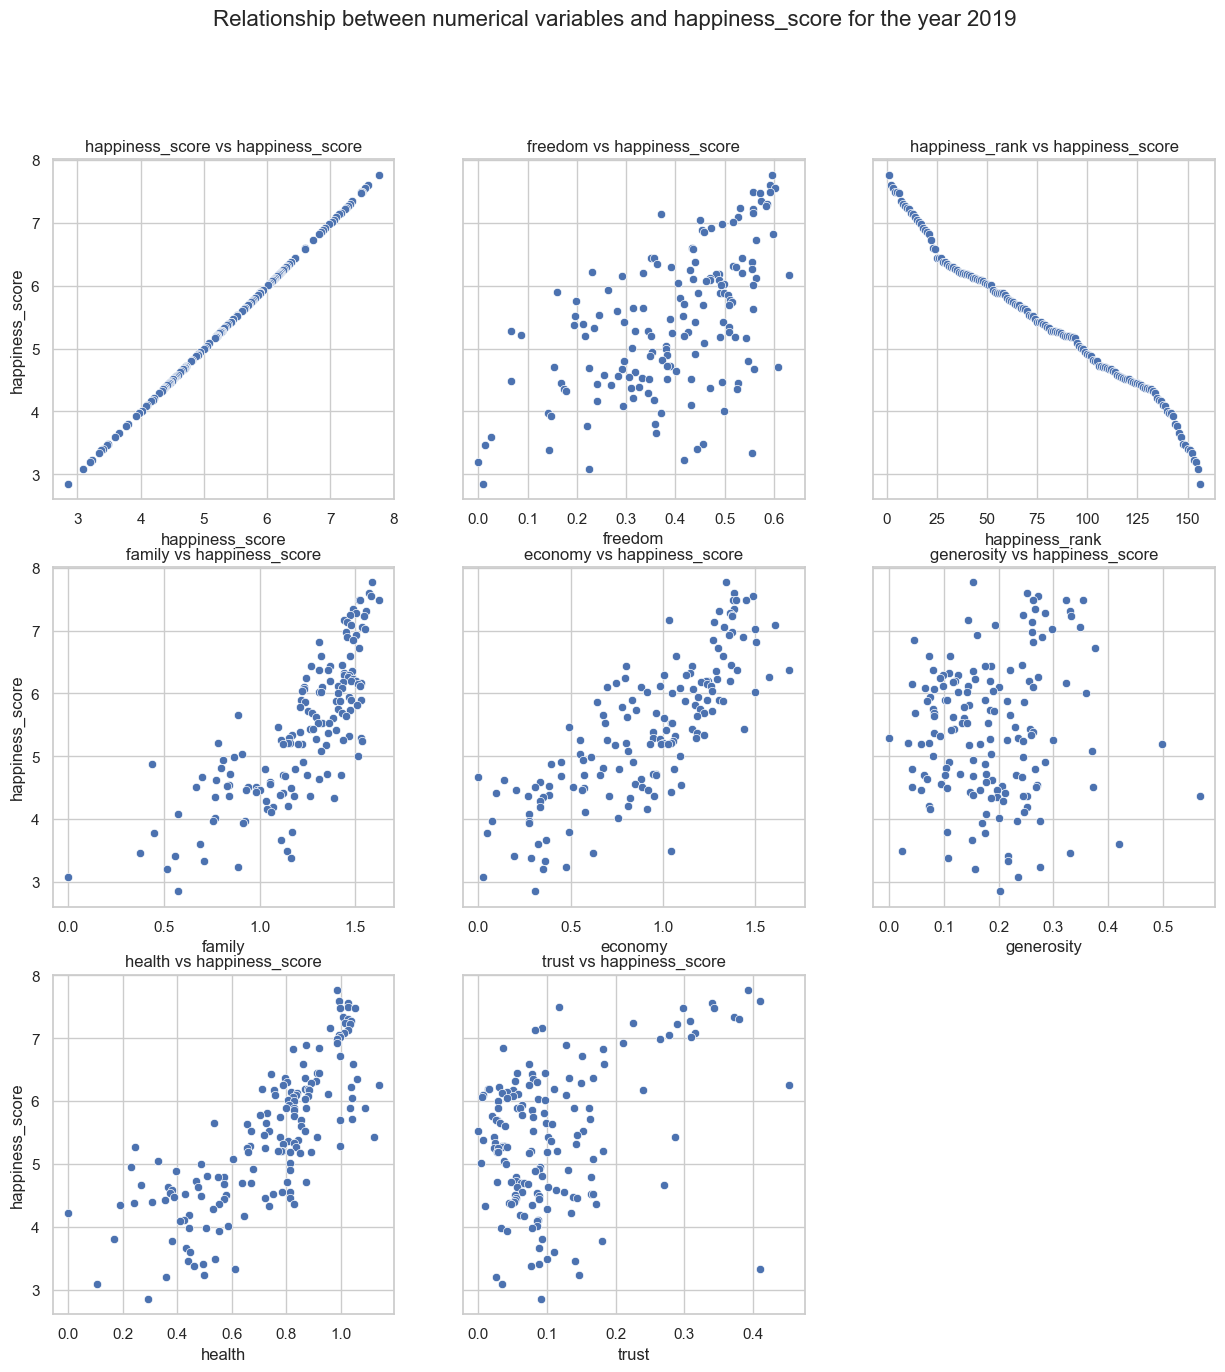

In [33]:
target_column = 'happiness_score'  # Reemplaza con tu columna objetivo

# Iterar sobre los DataFrames
for year, df in dfs.items():
    df_numeric = df.select_dtypes(include=['number'])
    num_columns = len(df_numeric.columns)

    # Definir el número de filas y columnas dinámicamente
    num_rows = int(np.ceil(num_columns / 3))  # Ajusta el divisor según el número máximo de columnas por fila
    num_cols = min(3, num_columns)  # Máximo 3 columnas por fila para mejor organización

    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 5 * num_rows), sharey=True)
    axes = axes.flatten()  # Asegurar que sea una lista plana para iterar fácilmente

    # Iterar sobre las columnas numéricas y graficarlas en subgráficas
    for ax, column in zip(axes, df_numeric.columns):
        sns.scatterplot(x=df[column], y=df[target_column], ax=ax)
        ax.set_title(f"{column} vs {target_column}")
        ax.set_xlabel(column)

    # Ocultar ejes no utilizados
    for i in range(num_columns, len(axes)):
        fig.delaxes(axes[i])

    fig.suptitle(f"Relationship between numerical variables and {target_column} for the year {year}", fontsize=16)
    
    plt.show()

### **Scatterplots interpretation**

These scatterplots display the relationship between the target variable, `happiness_score`, and factors like freedom, economy, health, and family support (for each year).

- **Freedom vs Happiness Score:** A positive trend suggests that greater freedom is associated with higher happiness scores.
- **Economy vs Happiness Score:** A strong positive correlation is evident—countries with better economies tend to have happier populations.
- **Health vs Happiness Score:** A clear upward trend indicates that better health is linked to increased happiness, emphasizing the importance of physical well-being.
- **Family vs Happiness Score:** The data shows a positive correlation, reinforcing the emotional and social impact of family connections.

Regarding linearity:

- **Trust and Generosity** appear to have a more scattered pattern, suggesting they may not follow a strict linear relationship. While their impact on happiness is positive, the connection might be influenced by other factors or exhibit diminishing returns at higher levels.


As for the **negative correlation between rank and happiness score**, the relationship exists because the ranking system is in **descending order**—meaning:
- Countries with **higher happiness scores** are given **lower rank numbers** (closer to 1).
- Countries with **lower happiness scores** receive **higher rank numbers** (closer to last place).

This is an **inverse relationship**, but not necessarily an indication of causation—it's simply a **mechanical consequence** of how the ranking system is structured. If happiness scores were plotted against rank, the trend would slope downward, reinforcing that **as happiness increases, rank decreases**.

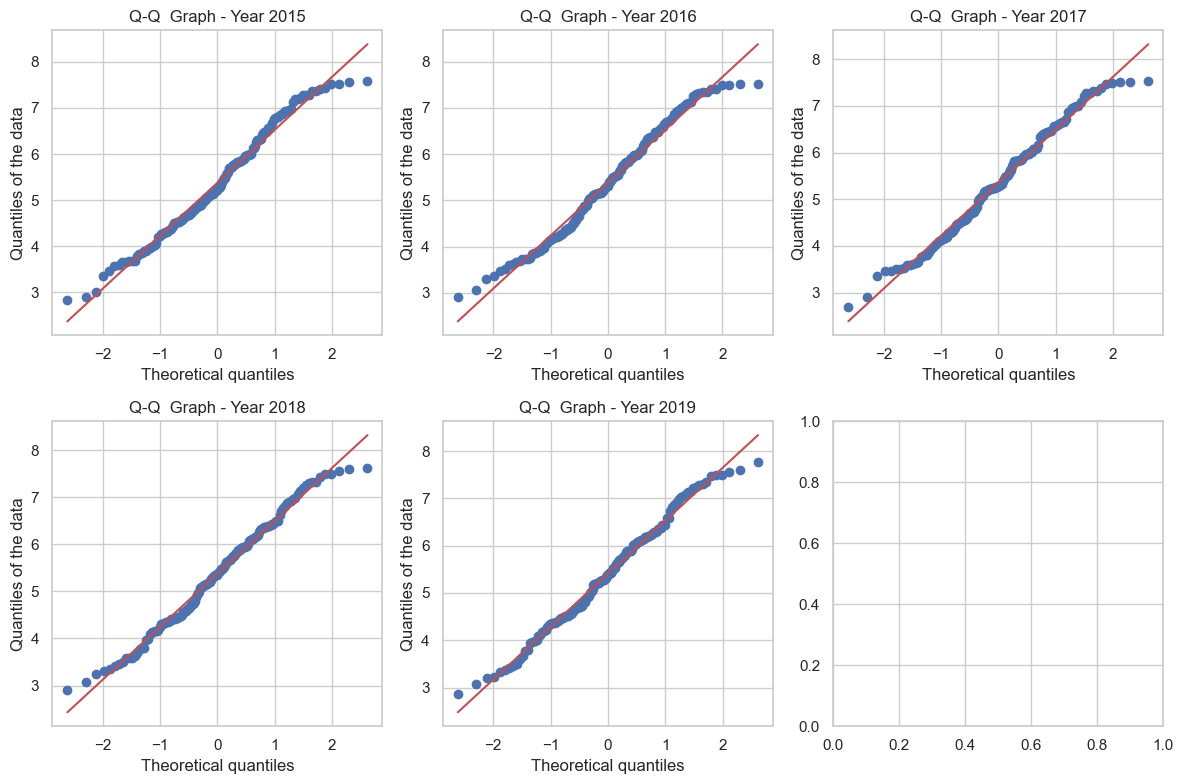

In [34]:
# Definir número de filas y columnas
num_rows = 2
num_cols = 3

# Crear la figura con subgráficos
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12, 8))

# Iterar sobre cada DataFrame y graficar en la posición correcta
for idx, (year, df) in enumerate(dfs.items()):
    row = idx // num_cols  # Calcular la fila correcta
    col = idx % num_cols   # Calcular la columna correcta

    column_name = "happiness_score"  # Cambia esto por el nombre correcto
    data = df[column_name].dropna()  # Eliminar valores NaN
    
    # Crear gráfico Q-Q en la posición correspondiente
    stats.probplot(data, dist="norm", plot=axes[row, col])
    axes[row, col].set_title(f"Q-Q  Graph - Year {year}")
    axes[row, col].set_xlabel("Theoretical quantiles")
    axes[row, col].set_ylabel("Quantiles of the data")

# Ajustar el diseño para evitar superposición de gráficos
plt.tight_layout()
plt.show()

### **Q-Q plots**

The Q-Q plots for each year (2015–2019) compare the quantiles of the dataset against a theoretical normal distribution, helping assess whether the target variable (`happiness_score`) follows normality. 

- **General trend:** The blue dots closely align with the red line in the middle range of each plot, suggesting the data follows a normal distribution fairly well in that region.
- **Deviations at the tails:** In all years, there are deviations at the lower and upper extremes—some points stray above or below the red line. This indicates that the dataset may have heavier or lighter tails than expected under normality, possibly suggesting skewness or kurtosis effects.
- **Consistency across years:** The patterns appear fairly stable, meaning the distribution characteristics did not change drastically from year to year.
- **Empty sixth plot:** It does not contain any data, so it does not contribute to the analysis.

Overall, these plots suggest the data is approximately normal but may exhibit slight deviations at the tails.

In [36]:
# Crear una lista para almacenar los resultados
results = []

# Calcular skewness y kurtosis para cada año
for year, df in dfs.items():
    data = df["happiness_score"].dropna()
    skewness = skew(data)
    kurt = kurtosis(data)
    
    # Interpretaciones
    skew_interpretation = "Slight right skew" if skewness > 0 else "Slight left skew" if skewness < 0 else "Approximately symmetric"
    kurt_interpretation = "High kurtosis (extreme values)" if kurt > 3 else "Low kurtosis (uniform distribution)"
    
    # Agregar resultados a la lista
    results.append([year, round(skewness, 4), round(kurt, 4), skew_interpretation, kurt_interpretation])

# Convertir la lista en un DataFrame
table = pd.DataFrame(results, columns=["Year", "Skewness", "Kurtosis", "Skewness Interpretation", "Kurtosis Interpretation"])

# Mostrar la tabla
table

,Year,Skewness,Kurtosis,Skewness Interpretation,Kurtosis Interpretation
0,2015,0.0968,-0.7895,Slight right skew,Low kurtosis (uniform distribution)
1,2016,0.0433,-0.8999,Slight right skew,Low kurtosis (uniform distribution)
2,2017,0.0095,-0.7649,Slight right skew,Low kurtosis (uniform distribution)
3,2018,0.0150,-0.7264,Slight right skew,Low kurtosis (uniform distribution)
4,2019,0.0113,-0.6273,Slight right skew,Low kurtosis (uniform distribution)


### **Skewness & Kurtosis Interpretation**

1️⃣ **Skewness** is **very low** across all years, meaning the distribution is **almost symmetric**, with only a slight rightward bias.  
2️⃣ **Kurtosis** is **negative** in all cases, indicating that the distribution is **platykurtic** (flatter and with fewer extreme values). This suggests that the data is more concentrated around the mean, without long tails.  

**How does this affect model selection?**  
- Since **there is no strong skew**, it is unnecessary to use models that correct extreme asymmetry (such as Gamma or logit).  
- Low kurtosis indicates **moderate data variability**, which may favor a **standard linear model**.  
- If values are restricted between **0 and 10**, a **Beta Regression** (with Min-Max Scaling transformation) could be a good option.  
- We can also try a **Classic Linear Regression** or a **GLM with identity function**, as the distribution appears quite stable. 

In [50]:
# Iterate over each year and calculate VIF and Tolerance for numeric predictors (excluding 'Happiness Score')
for year, df in dfs.items():
    # Select numeric columns and drop rows with missing values
    predictors = df.select_dtypes(include=["number"]).dropna()
    
    # Remove 'Happiness Score' if it exists
    predictors = predictors.drop(columns=["happiness_score"], errors="ignore")
    
    # Skip if not enough variables left
    if predictors.shape[1] < 2:
        print(f"\n⚠️ Not enough numeric variables to compute VIF for the year {year}.")
        continue

    # Compute VIF and Tolerance
    vif_data = pd.DataFrame()
    vif_data["Variable"] = predictors.columns
    vif_data["VIF"] = [variance_inflation_factor(predictors.values, i) for i in range(predictors.shape[1])]
    vif_data["Tolerance"] = 1 / vif_data["VIF"]
    
    print(f"\n📊 VIF and Tolerance for the year {year} (excluding 'Happiness Score')")
    print(vif_data.round(3))



📊 VIF and Tolerance for the year 2015 (excluding 'Happiness Score')
         Variable     VIF  Tolerance
0         freedom  15.358      0.065
1  happiness_rank   2.802      0.357
2          family  21.485      0.047
3         economy  23.453      0.043
4      generosity   5.673      0.176
5          health  22.671      0.044
6           trust   3.474      0.288

📊 VIF and Tolerance for the year 2016 (excluding 'Happiness Score')
         Variable     VIF  Tolerance
0         freedom  12.490      0.080
1  happiness_rank   2.356      0.424
2          family  18.260      0.055
3         economy  28.005      0.036
4      generosity   5.383      0.186
5          health  23.660      0.042
6           trust   3.702      0.270

📊 VIF and Tolerance for the year 2017 (excluding 'Happiness Score')
         Variable     VIF  Tolerance
0         freedom  13.453      0.074
1  happiness_rank   3.152      0.317
2          family  29.320      0.034
3         economy  30.939      0.032
4      generosit

Thanks for sharing the results! Here’s a **general analysis and recommendations** based on the VIF and Tolerance values from 2015 to 2019:

---

### ⚠️ **Variables with Severe Multicollinearity**

Generally, a **VIF > 10** (or Tolerance < 0.1) indicates **high multicollinearity**, which can distort regression model coefficients.

The following variables consistently show **severe multicollinearity across all years**:

| Variable    | Comment                                   |
|------------|-------------------------------------------|
| **family**  | VIF between 21 and 39. The worst case.   |
| **economy** | Very high VIF (23–31), worst in 2017.    |
| **health**  | VIF between 22 and 34. Also highly collinear. |
| **freedom** | Elevated VIF (12–15), but less critical. |

---

### ✅ **Variables with Acceptable Multicollinearity**

The following variables maintain a reasonable VIF (usually < 5):

| Variable            | VIF Range | Comment                         |
|--------------------|----------|--------------------------------|
| **happiness_rank** | 2.3 – 3.3 | Very acceptable.               |
| **generosity**     | 5.1 – 5.6 | Slightly high but manageable.  |
| **trust**         | 3.4 – 3.7 | Not a serious problem.        |


### **Let´s review the correlation matrix again to decide how to handle multicollinearity**



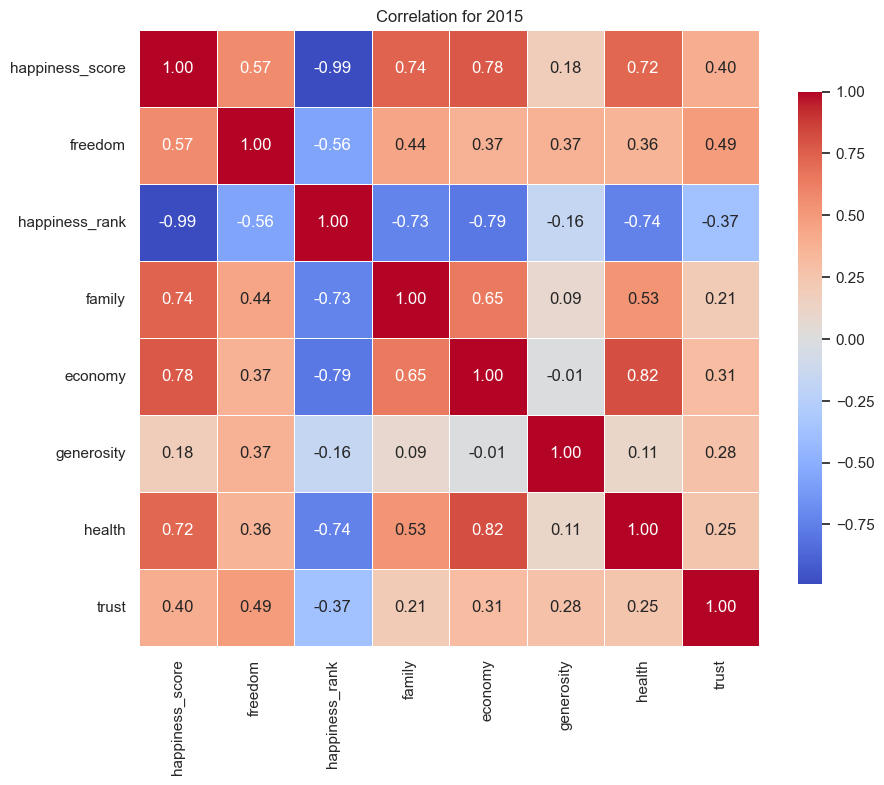

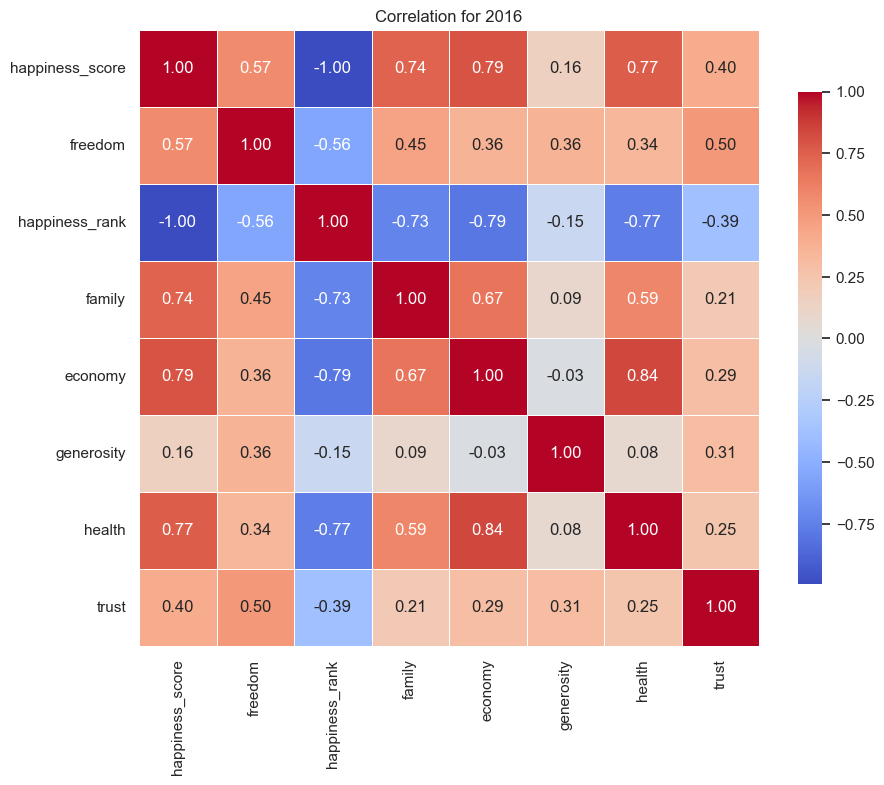

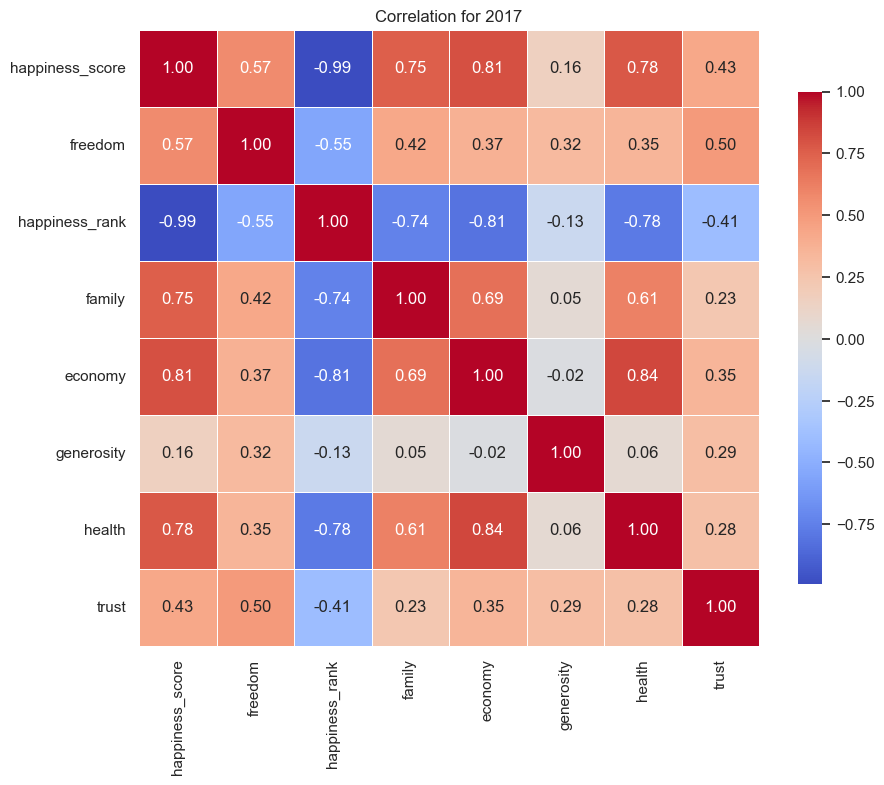

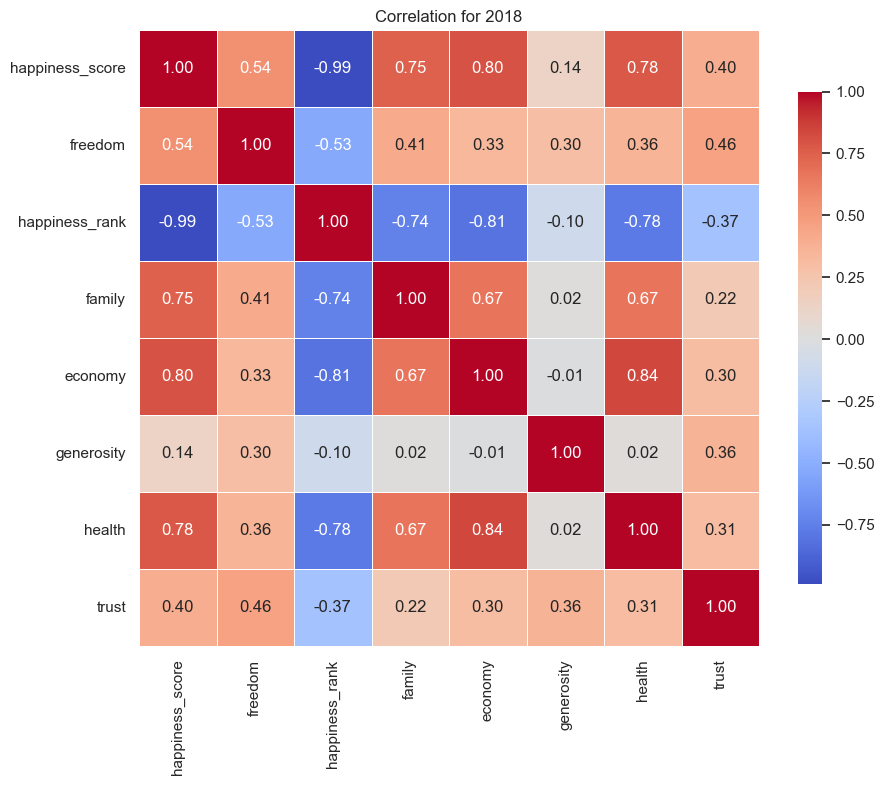

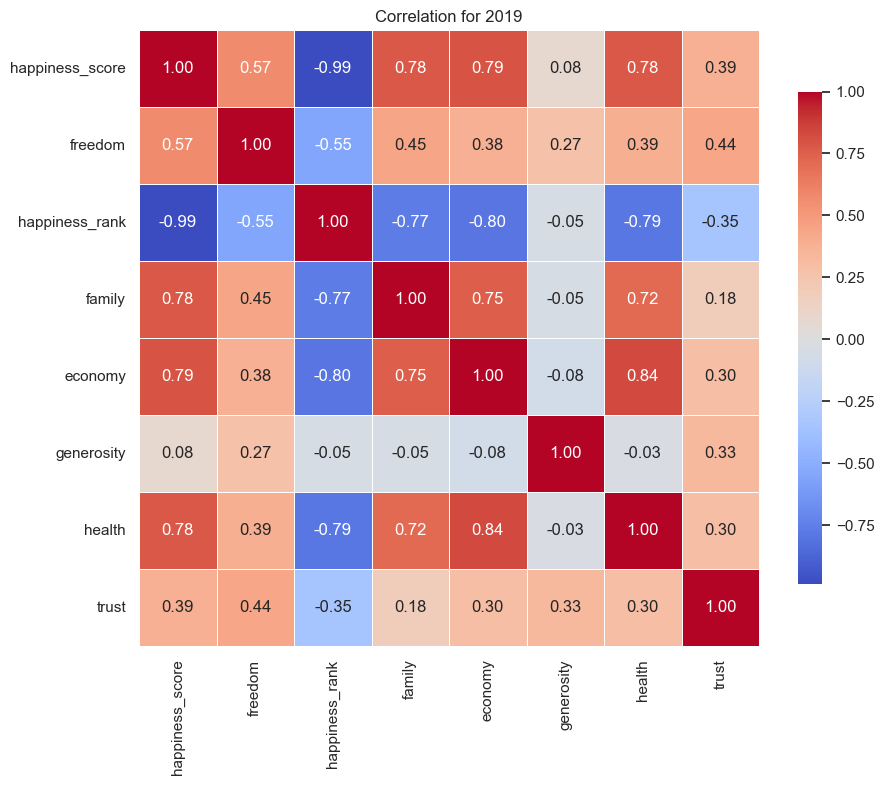

In [ ]:
for year, df in dfs.items():

    df_numeric = df.select_dtypes(include=['number'])

    corr = df_numeric.corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, cbar_kws={'shrink': 0.8})

    plt.title(f"Correlation for {year}")
    plt.show()

### **Collinearity Analysis**

From th **correlation heatmaps**, we can confirm what the VIF values already indicated: there's strong multicollinearity among several predictors, especially those related to general well-being:

* `economy` and `health`
* `economy` and `family`
* `family` and `health`
* All three are also strongly correlated with `happiness_score`.


In this case of highly correlated variables ( `economy`, `health`, `family`), we could use the following strategy:


**Keep only one representative variable**

Use one variable as a **proxy** for the group. For example:

* `economy` could represent the group since it has the **highest correlation with `happiness_score` (0.78)**.
* Alternatively, as our analysis focuses on social aspects, we might keep `family` or `health`.

## **Conclusions**

In a **linear model**, ideally, we should use variables that exhibit a **linear relationship** with the target variable because linear regression assumes a linear dependency between predictors and the response. However, there are **ways to handle non-linearity** rather than just excluding those variables, like:


**Trying Non-Linear Models**  
   - If linear transformations don't work, we could consider **non-linear regression models** such as **Decision Trees, Random Forests, or Neural Networks**, which can capture more complex relationships.


So, our options to model our predictions are as follows:


## 🎯 **1. Generalized Linear Models (GLM)**  

| GLM Model                         | When to Use It                                                  |  
|------------------------------------|----------------------------------------------------------------|  
| **Linear Regression (OLS)**        | When the relationship is linear and residuals are normally distributed |  
| **GLM Gaussian (Identity Link)**   | Similar to OLS but more flexible (better handling of heteroscedasticity) |  
| **GLM Gamma (Log Link)**           | If the target variable is positive and right-skewed           |  
| **GLM Beta (Logit/Probit Link)**   | If the target is in (0,1) → requires scaling `happiness_score` |

---

## 🤖 **2. Supervised Machine Learning Models**  

| Model                                              | Main Advantages                                       | Considerations                         |  
|---------------------------------------------------|------------------------------------------------------|-----------------------------------------|  
| **Random Forest Regressor**                         | Robust, handles non-linearities, variable importance | Less interpretable                      |  
| **Gradient Boosting (XGBoost, LightGBM, CatBoost)** | High accuracy, excellent for tabular data            | Can overfit if not regularized           |  
| **Support Vector Regression (SVR)**                 | Useful when data doesn't have a clear linear form    | Sensitive to scaling                     |  
| **k-Nearest Neighbors (KNN)**                       | Simple and non-parametric                            | Requires scaling, sensitive to noise     |  
| **MLP Regressor (Neural Network)**                  | Learns complex relationships                        | Needs more data and fine-tuning          |  



## 🧪 **3. Regularized Models**  

| Model               | When to Use It                             |  
|--------------------|------------------------------------------|  
| **Ridge Regression** | When there is moderate multicollinearity  |  
| **Lasso Regression** | For automatic variable selection         |  
| **ElasticNet**       | Balanced combination of Ridge and Lasso  |  

---

## ✅ **Which One to Choose Based on our Case?**  

Given that:  

* Our variable is in the range \[0,10] because the **happiness ranking (score)** is derived from the **Cantril Ladder**, which measures life evaluation on a **0-10 scale**. A standard linear regression **may not be the best choice**, as it can predict values outside this interval.
* **Skewness ≈ 0** and **Kurtosis ≈ negative**  
* We want to interpret results and possibly explain happiness  

### 🔵 **Use as a baseline:**  
* `LinearRegression` or `GLM Gaussian`  
* If multicollinearity exists: try `Ridge` or `Lasso`  

### 🔴 **Higher accuracy:**  
* `RandomForestRegressor`  
* `XGBoostRegressor`  

### 🟢 **If we want a bounded distribution:**  
* `Beta Regression` (rescaling target between 0 and 1)  


### **Decision Summary**
- **Keep variables with a clear linear trend** (like Freedom, Economy, Health, and Family).   
- **Consider non-linear models** if transformations don't help.


To model **continuous values between 0 and 10** using a **Generalized Linear Model (GLM)** we could:
---

### ✅ 1. **Rescale the Target and Use a Beta Regression (if values are in (0, 1))**

The **Beta distribution** is appropriate for modeling continuous data **strictly between 0 and 1**. To use it for a range **between 0 and 10**, we need to **rescale** your target:


---

### ✅ 2. **Use a Gamma GLM (if data is skewed and positive)**

If your target is continuous, **positive**, and potentially **right-skewed**, a **Gamma GLM with a log link** is appropriate:

```python
# y must be > 0
model = smf.glm("y ~ freedom + economy + health", 
                data=df, 
                family=sm.families.Gamma(link=sm.families.links.log())).fit()

print(model.summary())
```

---

### ✅ 3. **Use a Gaussian (Normal) GLM for simplicity**

If the data between 0 and 10 is roughly **symmetric**, a simple **Gaussian GLM** (like linear regression) is sufficient:

```python
model = smf.glm("y ~ freedom + economy + health", 
                data=df, 
                family=sm.families.Gaussian()).fit()

print(model.summary())
```

---

### 🎯 Summary of GLM Options for \[0, 10] Targets

| Target Characteristics         | Recommended GLM Type | Notes                                      |
| ------------------------------ | -------------------- | ------------------------------------------ |
| Bounded in (0, 10), rescalable | **Beta Regression**  | Rescale to (0,1), avoids modeling extremes |
| Positive, skewed               | **Gamma Regression** | Use log link for multiplicative effects    |
| Continuous, near-normal        | **Gaussian GLM**     | Most interpretable and easy to use         |



## **Saving the transformed concatenated Dataframes**

In [60]:
# Create an empty list to store DataFrames
df_list = []

# Iterate through each DataFrame in `dfs` and add the 'year' column
for year, df in dfs.items():
    df["year"] = year  # Add year column
    df_list.append(df)  # Store modified DataFrame

# Concatenate all DataFrames into a single one
df_final = pd.concat(df_list, ignore_index=True)

# Save to CSV
df_final.to_csv("../data/interim/happiness_data.csv", index=False)

print("✅ CSV file 'happiness_data.csv' saved successfully!")

✅ CSV file 'happiness_data.csv' saved successfully!
